# Libraries

In [17]:
import pandas as pd
from IPython.display import HTML
import os
import cv2
import matplotlib.pyplot as plt
import torch
import clip
import pandas as pd
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import cv2
from IPython.display import display, HTML
import base64
import io

# Data 

## Load data

We will use the 1K [MSR-VTT dataset](https://www.microsoft.com/en-us/research/publication/msr-vtt-a-large-video-description-dataset-for-bridging-video-and-language/), a subset of the Microsoft Research Video to Text dataset designed for open-domain video captioning

In [2]:
! curl -L https://github.com/towhee-io/examples/releases/download/data/text_video_search.zip -O
! unzip -q -o text_video_search.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  210M  100  210M    0     0  3027k      0  0:01:11  0:01:11 --:--:-- 3093k210M   34 73.1M    0     0  2932k      0  0:01:13  0:00:25  0:00:48 3075k


In [3]:
data = pd.read_csv('MSRVTT_JSFUSION_test.csv')[['video_id', 'sentence']]
data.head()

,video_id,sentence
0,video9770,a person is connecting something to system
1,video9771,a little girl does gymnastics
2,video7020,a woman creating a fondant baby and flower
3,video9773,a boy plays grand theft auto 5
4,video7026,a man is giving a review on a vehicle


## Explore Data

In [4]:
print(f"we have {data.shape[0]} videos in the dataset")

we have 1000 videos in the dataset


Let's plot few examples videos with captions


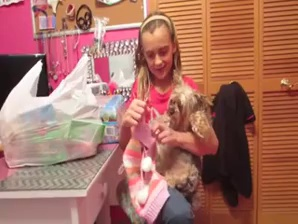


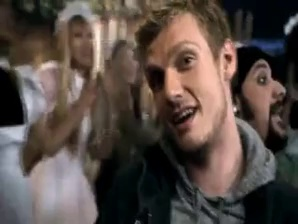


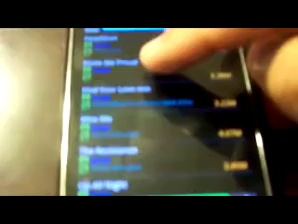

In [23]:
# Randomly select a few examples
num_examples = 3  # Specify how many examples to display
selected_examples = data.sample(num_examples, random_state=42)

# Display selected examples with videos
for _, row in selected_examples.iterrows():
    video_id = row['video_id']
    sentence = row['sentence']
    video_path = f"test_1k_compress/{video_id}.mp4"
    
    # Get video thumbnail
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()
    
    if ret:
        # Convert BGR to RGB using PIL
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame)
        
        # Save to base64 using PIL
        buffer = io.BytesIO()
        pil_image.save(buffer, format='JPEG', quality=95)
        img_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')
        
        # Display caption, thumbnail and video
        display(HTML(f"""
        <div style="border: 1px solid #ddd; padding: 10px; margin: 10px 0;">
            <p><b>Caption:</b> {sentence}</p>
            
            <!-- Thumbnail for GitHub -->
            <img src="data:image/jpeg;base64,{img_base64}" 
                 alt="Video thumbnail for {video_id}" 
                 style="max-width: 600px; width: 100%; margin-bottom: 10px;">
            
            <!-- Video player (will work in Jupyter) -->
            <video width="600" controls>
              <source src="{video_path}" type="video/mp4">
              Your browser does not support the video tag.
            </video>
            
            <p style="color: #666; font-style: italic;">Video: {video_path}</p>
        </div>
        <hr>
        """))
    else:
        display(HTML(f"""
        <div style="border: 1px solid #ddd; padding: 10px; margin: 10px 0;">
            <p><b>Caption:</b> {sentence}</p>
            <p>(Video preview not available: {video_path})</p>
            
            <!-- Video player (will work in Jupyter) -->
            <video width="600" controls>
              <source src="{video_path}" type="video/mp4">
              Your browser does not support the video tag.
            </video>
        </div>
        <hr>
        """))

## Data Statistics

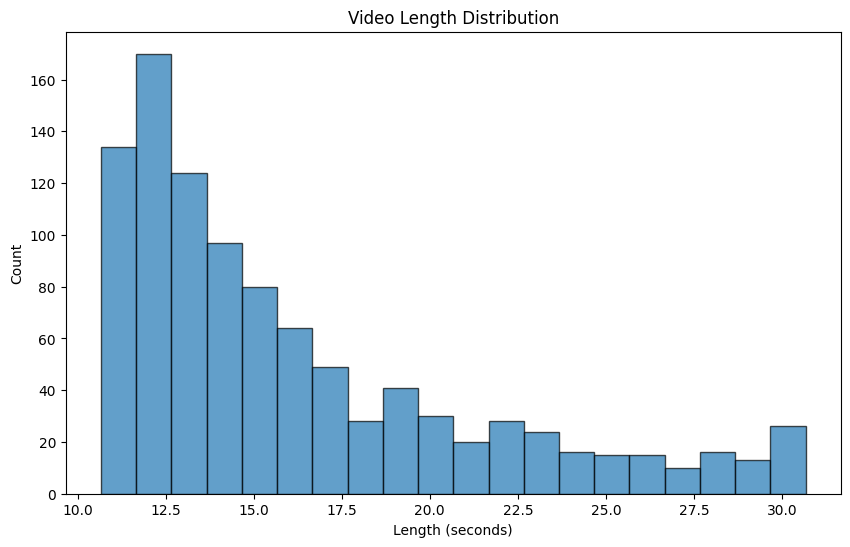

In [6]:
# Function to get video length in seconds
def get_video_length(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None
    length = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    return length

# Calculate video lengths
video_dir = "test_1k_compress"  # Path to the folder with videos
video_lengths = []

for video_id in data['video_id']:
    video_path = os.path.join(video_dir, f"{video_id}.mp4")
    if os.path.exists(video_path):
        length = get_video_length(video_path)
        if length:
            video_lengths.append(length)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(video_lengths, bins=20, edgecolor="k", alpha=0.7)
plt.title("Video Length Distribution")
plt.xlabel("Length (seconds)")
plt.ylabel("Count")
plt.show()


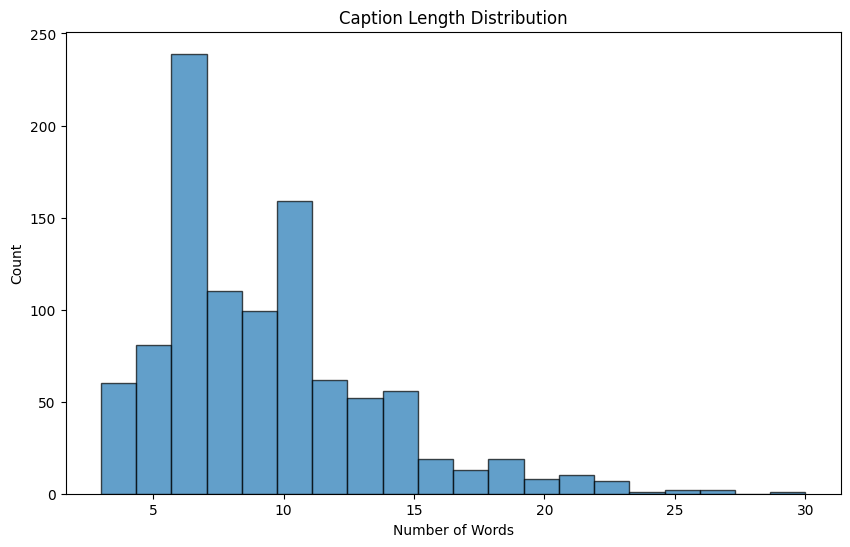

In [7]:
# Calculate caption lengths
data['caption_length'] = data['sentence'].apply(lambda x: len(x.split()))

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(data['caption_length'], bins=20, edgecolor="k", alpha=0.7)
plt.title("Caption Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()


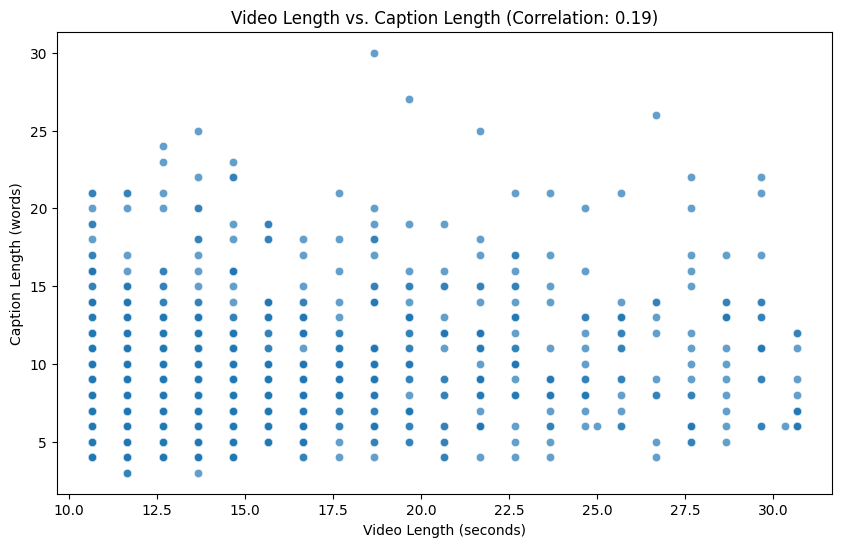

In [8]:
import seaborn as sns
import numpy as np

# Combine video length with caption length
video_data = []

for video_id, caption in zip(data['video_id'], data['sentence']):
    video_path = os.path.join(video_dir, f"{video_id}.mp4")
    if os.path.exists(video_path):
        video_length = get_video_length(video_path)
        if video_length:
            caption_length = len(caption.split())
            video_data.append((video_length, caption_length))

# Convert to a DataFrame for easier analysis
correlation_df = pd.DataFrame(video_data, columns=['Video Length (s)', 'Caption Length'])

# Compute correlation
correlation = correlation_df.corr().iloc[0, 1]

# Plot the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(data=correlation_df, x='Video Length (s)', y='Caption Length', alpha=0.7)
plt.title(f"Video Length vs. Caption Length (Correlation: {correlation:.2f})")
plt.xlabel("Video Length (seconds)")
plt.ylabel("Caption Length (words)")
plt.show()


we can see that there is no correlation between video length and description lergth

# Video Search System using CLIP

**CLIP Base Architecture**
![CLIP Base Architecture](src/clip.PNG)

CLIP (Contrastive Language-Image Pre-training) is trained on millions of (image, text) pairs from the internet. During training, it learns to:
- Encode images and text into the same embedding space
- Maximize similarity between matching image-text pairs
- Minimize similarity between non-matching pairs
- Create robust and generalizable visual-textual representations

**Video Search System Architecture**
![CLIP Video Search Architecture](src/diagram.svg)

**System Components**

**Video Processing (Offline)**
- Extract 8 evenly spaced frames from each video
- Each frame passes through CLIP's Vision Transformer (ViT) encoder
- Get 512-dimensional embedding for each frame
- Average the frame embeddings to get a single video representation
- Store embeddings in index for fast retrieval

**Text Processing (Online)**
- Take the search query (e.g., "cooking pasta")
- Pass through CLIP's text encoder (transformer-based)
- Get a 512-dimensional text embedding

**Similarity Matching**
- Calculate cosine similarity between the text embedding and all video embeddings
- Cosine similarity measures the angle between vectors: closer to 1 means more similar
- Rank videos by similarity scores
- Return top-k most similar videos

**Key Features**
- Both video and text are mapped to the same 512-dimensional space
- CLIP was trained on millions of image-text pairs to align visual and textual features
- Mean pooling of frames captures the overall video content
- Cosine similarity is scale-invariant, focusing on directional similarity
- The system can find relevant videos even with different phrasing due to CLIP's robust text understanding

In [26]:
class VideoDataset:
    def __init__(self, df, video_base_path="test_1k_compress"):
        self.df = df
        self.video_base_path = video_base_path
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)
        self.video_embeddings = None
        
    def get_video_frames(self, video_path, num_frames=8):
        """Extract evenly spaced frames from video"""
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames_to_sample = np.linspace(0, total_frames-1, num_frames, dtype=int)
        
        frames = []
        for frame_idx in frames_to_sample:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                frame = self.preprocess(frame)
                frames.append(frame)
        
        cap.release()
        return torch.stack(frames)
    
    def compute_video_embeddings(self, batch_size=8):
        """Compute CLIP embeddings for all videos"""
        video_embeddings = []
        
        with torch.no_grad():
            for idx in tqdm(range(len(self.df))):
                video_id = self.df.iloc[idx]['video_id']
                video_path = f"{self.video_base_path}/{video_id}.mp4"
                
                # Extract frames and get their embeddings
                frames = self.get_video_frames(video_path)
                frame_embeddings = []
                
                for i in range(0, len(frames), batch_size):
                    batch = frames[i:i+batch_size].to(self.device)
                    embedding = self.model.encode_image(batch)
                    frame_embeddings.append(embedding)
                
                # Combine frame embeddings (mean pooling)
                video_embedding = torch.cat(frame_embeddings).mean(dim=0)
                video_embeddings.append(video_embedding.cpu().numpy())
        
        self.video_embeddings = np.array(video_embeddings)
        return self.video_embeddings

    def search(self, query, top_k=5, display_results=True):
        """Search videos based on text query and optionally display results"""
        if self.video_embeddings is None:
            print("Computing video embeddings first...")
            self.compute_video_embeddings()

        with torch.no_grad():
            # Encode text query
            text_tokens = clip.tokenize([query]).to(self.device)
            text_embedding = self.model.encode_text(text_tokens)
            text_embedding = text_embedding.cpu().numpy()
        
        # Compute similarities
        similarities = cosine_similarity(text_embedding, self.video_embeddings)[0]
        
        # Get top-k results
        top_indices = np.argsort(similarities)[-top_k:][::-1]
        results = []
        
        for idx in top_indices:
            result = {
                'video_id': self.df.iloc[idx]['video_id'],
                'sentence': self.df.iloc[idx]['sentence'],
                'similarity': similarities[idx]
            }
            results.append(result)
            
            if display_results:
                video_path = f"{self.video_base_path}/{result['video_id']}.mp4"
                self.display_video_result(result['sentence'], video_path, result['similarity'])
        
        return results

    def display_video_result(self, caption, video_path, similarity=None):
        """Display a single video result with its caption, thumbnail, and similarity score"""

        similarity_text = f" (Similarity: {similarity:.3f})" if similarity is not None else ""

        # Get video thumbnail
        cap = cv2.VideoCapture(video_path)
        ret, frame = cap.read()
        cap.release()

        if ret:
            # Convert BGR to RGB using PIL
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(frame)

            # Save to base64 using PIL
            buffer = io.BytesIO()
            pil_image.save(buffer, format='JPEG', quality=95)
            img_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')

            # Display caption, thumbnail and video
            display(HTML(f"""
            <div style="border: 1px solid #ddd; padding: 10px; margin: 10px 0;">
                <p><b>Caption:</b> {caption}{similarity_text}</p>

                <!-- Thumbnail for GitHub -->
                <img src="data:image/jpeg;base64,{img_base64}" 
                     alt="Video thumbnail" 
                     style="max-width: 600px; width: 100%; margin-bottom: 10px;">

                <!-- Video player (will work in Jupyter) -->
                <video width="600" controls>
                  <source src="{video_path}" type="video/mp4">
                  Your browser does not support the video tag.
                </video>

                <p style="color: #666; font-style: italic;">Video: {video_path}</p>
            </div>
            <hr>
            """))
        else:
            display(HTML(f"""
            <div style="border: 1px solid #ddd; padding: 10px; margin: 10px 0;">
                <p><b>Caption:</b> {caption}{similarity_text}</p>
                <p>(Video preview not available: {video_path})</p>

                <!-- Video player (will work in Jupyter) -->
                <video width="600" controls>
                  <source src="{video_path}" type="video/mp4">
                  Your browser does not support the video tag.
                </video>
            </div>
            <hr>
            """))

    def display_random_examples(self, num_examples=3, seed=42):
        """Display random examples from the dataset"""
        selected_examples = self.df.sample(num_examples, random_state=seed)
        
        for _, row in selected_examples.iterrows():
            video_id = row['video_id']
            sentence = row['sentence']
            video_path = f"{self.video_base_path}/{video_id}.mp4"
            self.display_video_result(sentence, video_path)

    def evaluate_search(self, test_queries=None, num_test_queries=100):
        """
        Evaluate search engine using ground truth sentences as queries
        Returns precision@k and similarity scores
        """
        if test_queries is None:
            test_queries = self.df.sample(num_test_queries)
            
        results = []
        
        for idx, row in test_queries.iterrows():
            query = row['sentence']
            true_video_id = row['video_id']
            
            # Get search results
            search_results = self.search(query, top_k=10, display_results=False)
            
            # Check if true video is in top-k
            retrieved_videos = [r['video_id'] for r in search_results]
            rank = retrieved_videos.index(true_video_id) + 1 if true_video_id in retrieved_videos else -1
            
            results.append({
                'query': query,
                'true_video': true_video_id,
                'rank': rank,
                'top1_accuracy': 1 if rank == 1 else 0,
                'top5_accuracy': 1 if 1 <= rank <= 5 else 0,
                'top10_accuracy': 1 if 1 <= rank <= 10 else 0,
                'similarity_score': search_results[0]['similarity'] if search_results else 0
            })
        
        results_df = pd.DataFrame(results)
        metrics = {
            'top1_accuracy': results_df['top1_accuracy'].mean(),
            'top5_accuracy': results_df['top5_accuracy'].mean(),
            'top10_accuracy': results_df['top10_accuracy'].mean(),
            'mean_similarity': results_df['similarity_score'].mean(),
            'median_rank': results_df[results_df['rank'] != -1]['rank'].median()
        }
        
        return metrics, results_df
    
    def generate_sentence_variants(self, sentence, num_variants=3):
        """
        Generate variations of a sentence using Ollama API with improved parsing
        """
        prompt = f"""Generate {num_variants} alternative descriptions for this scene. 
                    Keep the same meaning but use different words and structure.
                    Format: Return ONLY the variations, one per line, no prefixes or explanations.
                    Original: '{sentence}'"""

        try:
            response = requests.post(
                'http://opmlgpubuild01:11434/api/generate',
                json={
                    'model': 'llama3',
                    'prompt': prompt,
                    'stream': False,
                    'system': "You are a helpful assistant that generates alternative descriptions. Respond ONLY with the variations, one per line. No explanations or prefixes."
                }
            )
            response.raise_for_status()

            # Clean and parse response
            response_text = response.json()['response'].strip()
            variations = [v for v in response_text.split('\n') if v.strip() and 
                         not v.startswith(('Here are', '1.', '2.', '3.', '-', '•'))]

            if not variations:  # If no valid variations found
                return [f"Alternative description: {sentence}"] * num_variants

            # Ensure we have enough variations
            while len(variations) < num_variants:
                variations.append(variations[0])  # Duplicate first variation if needed

            return variations[:num_variants]

        except Exception as e:
            print(f"Error generating variations: {e}")
            return [f"Alternative description: {sentence}"] * num_variants

    def evaluate_robustness(self, num_samples=50, num_variants=3, top_k=5):
        """
        Evaluate search robustness using sentence variations, focusing on successful retrievals
        """
        sampled_data = self.df.sample(num_samples)
        robustness_results = []

        for _, row in tqdm(sampled_data.iterrows(), total=len(sampled_data)):
            original_sentence = row['sentence']
            true_video_id = row['video_id']

            # Get original search results
            original_results = self.search(original_sentence, top_k=top_k, display_results=False)
            original_ranks = {r['video_id']: idx + 1 for idx, r in enumerate(original_results)}

            # Only proceed if original query found the correct video
            if true_video_id in original_ranks:
                original_rank = original_ranks[true_video_id]

                # Generate variations
                variations = self.generate_sentence_variants(original_sentence, num_variants)

                # Test each variation
                for variant in variations:
                    variant_results = self.search(variant, top_k=top_k, display_results=False)
                    variant_ranks = {r['video_id']: idx + 1 for idx, r in enumerate(variant_results)}
                    variant_rank = variant_ranks.get(true_video_id, -1)

                    result = {
                        'original_sentence': original_sentence,
                        'variant_sentence': variant,
                        'true_video_id': true_video_id,
                        'original_rank': original_rank,
                        'variant_rank': variant_rank,
                        'rank_difference': abs(original_rank - (variant_rank if variant_rank != -1 else top_k + 1)),
                        'maintained_in_top_k': variant_rank != -1,
                        'original_similarity': original_results[0]['similarity'],
                        'variant_similarity': variant_results[0]['similarity']
                    }
                    robustness_results.append(result)

        results_df = pd.DataFrame(robustness_results)

        # Calculate metrics only for cases where original query was successful
        metrics = {
            'total_successful_queries': len(results_df),
            'maintained_in_top_k_ratio': results_df['maintained_in_top_k'].mean(),
            'mean_rank_difference': results_df['rank_difference'].mean(),
            'perfect_maintenance_ratio': (results_df['rank_difference'] == 0).mean(),
            'similarity_correlation': results_df[['original_similarity', 'variant_similarity']].corr().iloc[0,1],
            'avg_similarity_drop': (results_df['variant_similarity'] - results_df['original_similarity']).mean()
        }

        # Visualize results
        plt.figure(figsize=(15, 5))

        # Plot 1: Original vs Variant Ranks
        plt.subplot(1, 3, 1)
        valid_ranks = results_df[results_df['variant_rank'] != -1]
        plt.scatter(valid_ranks['original_rank'], valid_ranks['variant_rank'], alpha=0.5)
        plt.plot([1, top_k], [1, top_k], 'r--')  # Perfect maintenance line
        plt.xlabel('Original Rank')
        plt.ylabel('Variant Rank')
        plt.title('Rank Maintenance Analysis')

        # Plot 2: Original vs Variant Similarities
        plt.subplot(1, 3, 2)
        plt.scatter(results_df['original_similarity'], 
                   results_df['variant_similarity'], 
                   alpha=0.5)
        plt.plot([0, 1], [0, 1], 'r--')  # Perfect correlation line
        plt.xlabel('Original Similarity')
        plt.ylabel('Variant Similarity')
        plt.title('Similarity Comparison')

        # Plot 3: Rank Difference Distribution
        plt.subplot(1, 3, 3)
        sns.histplot(results_df['rank_difference'], bins=top_k)
        plt.xlabel('Rank Difference')
        plt.ylabel('Count')
        plt.title('Rank Difference Distribution')

        plt.tight_layout()
        plt.show()

        # Display successful examples of perfect maintenance
        print("\n🎯 Examples where ranking was perfectly maintained:")
        perfect_matches = results_df[results_df['rank_difference'] == 0].sample(min(3, len(results_df)))
        for _, row in perfect_matches.iterrows():
            print(f"\nOriginal [Rank: {row['original_rank']}]: {row['original_sentence']}")
            print(f"Variant [Rank: {row['variant_rank']}]: {row['variant_sentence']}")
            print(f"Similarity: {row['variant_similarity']:.3f}")

        # Display examples with largest rank changes (but only from successful retrievals)
        print("\n❌ Examples with largest rank differences (from successful retrievals):")
        worst_matches = results_df[results_df['maintained_in_top_k']].nlargest(3, 'rank_difference')
        for _, row in worst_matches.iterrows():
            print(f"\nOriginal [Rank: {row['original_rank']}]: {row['original_sentence']}")
            print(f"Variant [Rank: {row['variant_rank']}]: {row['variant_sentence']}")
            print(f"Original Similarity: {row['original_similarity']:.3f}")
            print(f"Variant Similarity: {row['variant_similarity']:.3f}")
            print(f"Rank Change: From {row['original_rank']} to {row['variant_rank']}")

        return metrics, results_df
    
    def analyze_best_worst_results(self, num_examples=5):
        """
        Analyze best and worst performing search results using self-retrieval
        Returns and displays top best and worst matches
        """
        all_results = []
        
        print("Analyzing all videos for best/worst matches...")
        for idx, row in tqdm(self.df.iterrows(), total=len(self.df)):
            query = row['sentence']
            true_video_id = row['video_id']
            
            # Get search results without displaying
            search_results = self.search(query, top_k=1, display_results=False)
            retrieved_video_id = search_results[0]['video_id']
            similarity = search_results[0]['similarity']
            
            all_results.append({
                'query': query,
                'true_video_id': true_video_id,
                'retrieved_video_id': retrieved_video_id,
                'similarity': similarity,
                'is_correct': true_video_id == retrieved_video_id
            })
        
        results_df = pd.DataFrame(all_results)
        
        # Get best matches
        print("\n🎯 Top Best Matches:")
        best_matches = results_df[results_df['is_correct']].nlargest(num_examples, 'similarity')
        for _, row in best_matches.iterrows():
            print(f"\nSimilarity: {row['similarity']:.3f}")
            video_path = f"{self.video_base_path}/{row['true_video_id']}.mp4"
            self.display_video_result(row['query'], video_path, row['similarity'])
        
        # Get worst matches
        print("\n❌ Top Worst Matches:")
        worst_matches = results_df[~results_df['is_correct']].nlargest(num_examples, 'similarity')
        for _, row in worst_matches.iterrows():
            print(f"\nQuery (Expected): {row['query']}")
            print(f"Similarity: {row['similarity']:.3f}")
            
            # Display expected video
            print("\nExpected Video:")
            video_path = f"{self.video_base_path}/{row['true_video_id']}.mp4"
            self.display_video_result(row['query'], video_path)
            
            # Display retrieved video
            print("\nRetrieved Video:")
            video_path = f"{self.video_base_path}/{row['retrieved_video_id']}.mp4"
            retrieved_sentence = self.df[self.df['video_id'] == row['retrieved_video_id']]['sentence'].iloc[0]
            self.display_video_result(retrieved_sentence, video_path, row['similarity'])
        
        return best_matches, worst_matches
    def analyze_errors_by_characteristics(self):
        """
        Analyze search errors based on query and video characteristics,
        focusing on key relationships and clear conclusions
        """
        error_analysis_results = []

        print("Analyzing errors across videos...")
        for idx, row in tqdm(self.df.iterrows(), total=len(self.df)):
            query = row['sentence']
            true_video_id = row['video_id']
            video_path = f"{self.video_base_path}/{true_video_id}.mp4"

            # Get video length
            cap = cv2.VideoCapture(video_path)
            video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) / cap.get(cv2.CAP_PROP_FPS)
            cap.release()

            # Get search results
            search_results = self.search(query, top_k=5, display_results=False)
            retrieved_video_id = search_results[0]['video_id']
            similarity = search_results[0]['similarity']

            result = {
                'query_length': len(query.split()),
                'video_length': video_length,
                'similarity': similarity,
                'is_correct': true_video_id == retrieved_video_id
            }
            error_analysis_results.append(result)

        results_df = pd.DataFrame(error_analysis_results)

        # Create visualizations
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # 1. Query Length vs Accuracy
        sns.boxplot(data=results_df, x='is_correct', y='query_length', ax=axes[0])
        axes[0].set_title('Query Length vs Accuracy')
        axes[0].set_xlabel('Correct Retrieval')
        axes[0].set_ylabel('Query Length (words)')

        # 2. Video Length vs Accuracy
        sns.boxplot(data=results_df, x='is_correct', y='video_length', ax=axes[1])
        axes[1].set_title('Video Length vs Accuracy')
        axes[1].set_xlabel('Correct Retrieval')
        axes[1].set_ylabel('Video Length (seconds)')

        # 3. Similarity Distribution
        sns.kdeplot(data=results_df, x='similarity', hue='is_correct', ax=axes[2])
        axes[2].set_title('Similarity Score Distribution')
        axes[2].set_xlabel('Similarity Score')

        plt.tight_layout()
        plt.show()

        # Calculate key statistics
        stats = {
            'query_length': {
                'correct_mean': results_df[results_df['is_correct']]['query_length'].mean(),
                'incorrect_mean': results_df[~results_df['is_correct']]['query_length'].mean(),
                'correlation': results_df['query_length'].corr(results_df['is_correct'])
            },
            'video_length': {
                'correct_mean': results_df[results_df['is_correct']]['video_length'].mean(),
                'incorrect_mean': results_df[~results_df['is_correct']]['video_length'].mean(),
                'correlation': results_df['video_length'].corr(results_df['is_correct'])
            },
            'similarity': {
                'correct_mean': results_df[results_df['is_correct']]['similarity'].mean(),
                'incorrect_mean': results_df[~results_df['is_correct']]['similarity'].mean(),
                'correlation': results_df['similarity'].corr(results_df['is_correct'])
            }
        }

        return results_df, stats

    def error_analysis_report(self, results_df, stats):
        """
        Generate concise error analysis report with clear conclusions
        """
        # Calculate accuracy thresholds
        short_queries = results_df['query_length'] <= results_df['query_length'].median()
        long_queries = ~short_queries
        short_videos = results_df['video_length'] <= results_df['video_length'].median()
        long_videos = ~short_videos

        conclusions = []

        # Query length impact
        short_query_acc = results_df[short_queries]['is_correct'].mean()
        long_query_acc = results_df[long_queries]['is_correct'].mean()
        query_conclusion = "SHORTER" if short_query_acc > long_query_acc else "LONGER"

        # Video length impact
        short_video_acc = results_df[short_videos]['is_correct'].mean()
        long_video_acc = results_df[long_videos]['is_correct'].mean()
        video_conclusion = "SHORTER" if short_video_acc > long_video_acc else "LONGER"

        conclusions.append("\n📊 BOTTOM LINE CONCLUSIONS:")
        conclusions.append(f"1. Queries: {query_conclusion} queries perform better")
        conclusions.append(f"   - Short query accuracy: {short_query_acc:.1%}")
        conclusions.append(f"   - Long query accuracy: {long_query_acc:.1%}")
        conclusions.append(f"   - Correlation with accuracy: {stats['query_length']['correlation']:.3f}")

        conclusions.append(f"\n2. Videos: {video_conclusion} videos perform better")
        conclusions.append(f"   - Short video accuracy: {short_video_acc:.1%}")
        conclusions.append(f"   - Long video accuracy: {long_video_acc:.1%}")
        conclusions.append(f"   - Correlation with accuracy: {stats['video_length']['correlation']:.3f}")

        conclusions.append("\n3. Key Findings:")
        conclusions.append(f"   - Average similarity for correct matches: {stats['similarity']['correct_mean']:.3f}")
        conclusions.append(f"   - Average similarity for incorrect matches: {stats['similarity']['incorrect_mean']:.3f}")
        conclusions.append(f"   - Overall correlation between similarity and accuracy: {stats['similarity']['correlation']:.3f}")

        return "\n".join(conclusions)


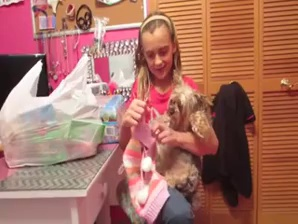


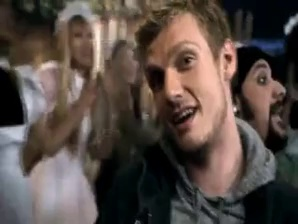


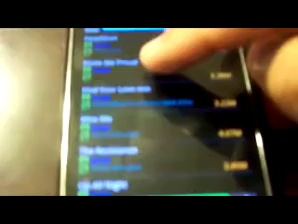

In [27]:
video_dataset = VideoDataset(data)

# Display some random examples
video_dataset.display_random_examples(num_examples=3)

## Free Text Search

Computing video embeddings first...


100%|██████████| 1000/1000 [01:48<00:00,  9.21it/s]



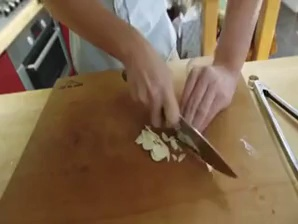


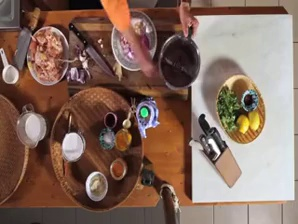


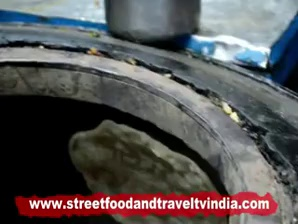


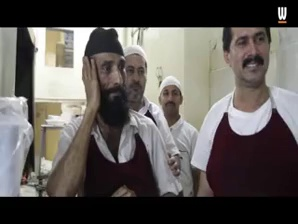


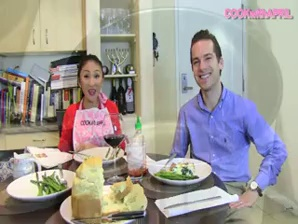

[{'video_id': 'video7799',
  'sentence': 'a guy chops up garlic and pours it over chicken frying in a pan',
  'similarity': 0.32813810748344985},
 {'video_id': 'video9693',
  'sentence': 'the chef adds fish sauce and fish paste to a large stainless steel cooking pot',
  'similarity': 0.32369178799849646},
 {'video_id': 'video9038',
  'sentence': 'a person is preparing some food',
  'similarity': 0.31827124177187527},
 {'video_id': 'video8325',
  'sentence': 'a man cooks some food in a kitchen',
  'similarity': 0.3143684495208409},
 {'video_id': 'video7911',
  'sentence': 'a woman is making a recipe in a sauce pan',
  'similarity': 0.3130432528109044}]

In [28]:
# Search with a text query 
video_dataset.search("a person cooking in the kitchen", top_k=5)

## Evaluation

**Evaluation of Video Search System**

To evaluate our video retrieval system, we test it on random queries from our dataset. The evaluation process:

1. Randomly sample 100 video descriptions as test queries
2. For each query:
  - Use the original video description as search query
  - Check if the system retrieves the correct video in top-k results
  - Measure the similarity score and ranking position

**The metrics include:**
- `top1_accuracy`: Percentage of queries where correct video is the first result
- `top5_accuracy`: Percentage of queries where correct video is in top 5 results  
- `top10_accuracy`: Percentage of queries where correct video is in top 10 results
- `mean_similarity`: Average similarity score across all queries
- `median_rank`: Median position of correct video in results

This provides a quantitative assessment of our system's retrieval performance. Higher accuracy scores and lower median rank indicate better search quality.

Additionally, we analyze robustness by testing variations of the same query and measuring how consistent the results are. This helps understand how well the system handles different ways of describing the same video content.

In [29]:
# Evaluate using random test queries
metrics, detailed_results = video_dataset.evaluate_search(num_test_queries=100)

print("Evaluation Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

Evaluation Results:
top1_accuracy: 0.260
top5_accuracy: 0.470
top10_accuracy: 0.590
mean_similarity: 0.312
median_rank: 2.000


## Error Analysis

**Analysis of Best and Worst Matches**

To better understand our system's strengths and weaknesses, we analyze the extreme cases - both successful and failed retrievals:

1. **Best Matches (num_examples=5)**
  - Cases where the correct video was retrieved with highest similarity scores
  - Shows pairs of queries and videos where CLIP embeddings work exceptionally well
  - Helps identify what types of content and descriptions are most reliably matched

2. **Worst Matches (num_examples=5)**
  - Cases where either:
    * The wrong video was retrieved with high confidence
    * The correct video was ranked much lower despite similar content
  - For each case, displays:
    * Original query and expected video
    * Retrieved video and its similarity score
    * The rank difference and similarity scores

This analysis helps us:
- Identify patterns in successful matches
- Understand types of queries that confuse the system
- Find potential improvements for handling challenging cases
- Better understand CLIP's strengths and limitations in video search

Analyzing all videos for best/worst matches...


100%|██████████| 1000/1000 [00:33<00:00, 29.91it/s]


🎯 Top Best Matches:

Similarity: 0.418



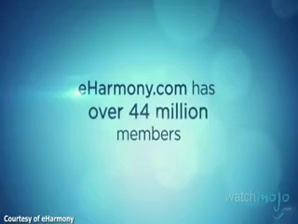


Similarity: 0.378



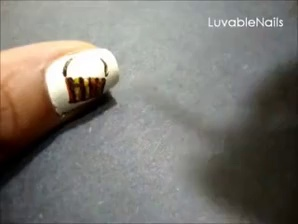


Similarity: 0.376



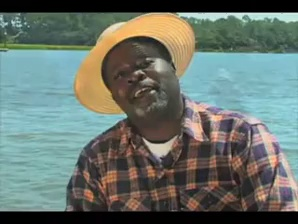


Similarity: 0.374



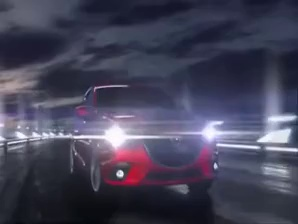


Similarity: 0.373



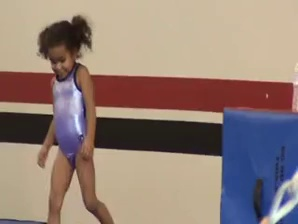


❌ Top Worst Matches:

Query (Expected): this is a vine sports compilation
Similarity: 0.396

Expected Video:



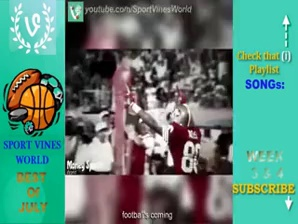


Retrieved Video:



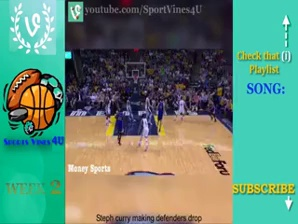


Query (Expected): a guy barbequeing potatoes
Similarity: 0.385

Expected Video:



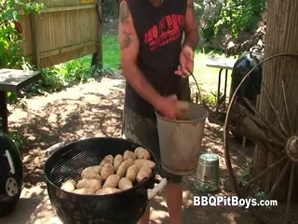


Retrieved Video:



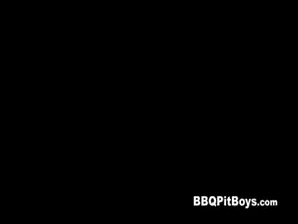


Query (Expected): a video showing footage from sporting events
Similarity: 0.370

Expected Video:



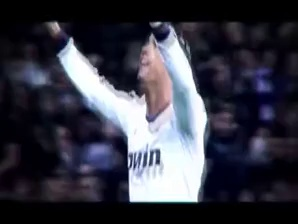


Retrieved Video:



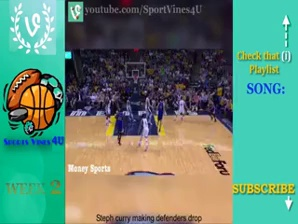


Query (Expected): a woman is making playdoh
Similarity: 0.365

Expected Video:



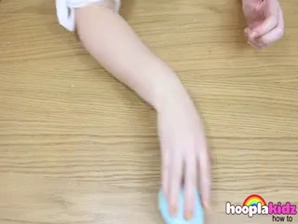


Retrieved Video:



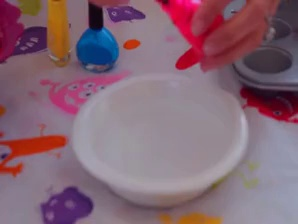


Query (Expected): different women in colorful clothing are walking down a runway for a fashion show
Similarity: 0.364

Expected Video:



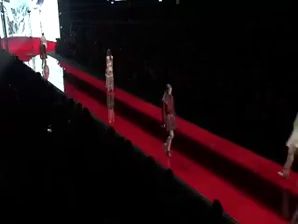


Retrieved Video:



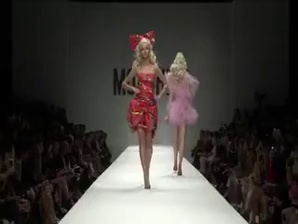

In [30]:
# Find and display best and worst performing searches
best_matches, worst_matches = video_dataset.analyze_best_worst_results(num_examples=5)

**Error Analysis and Characteristics Impact**

Comprehensive analysis of how different characteristics affect search performance:

1. **Query Analysis**
  - Studies relationship between query length and search accuracy
  - Determines if shorter/longer descriptions lead to better results
  - Measures correlation between query characteristics and success rate

2. **Video Analysis**
  - Examines impact of video length on retrieval accuracy
  - Looks for patterns in successful vs. unsuccessful retrievals
  - Helps understand if longer/shorter videos are harder to match

The report provides:
- Statistical correlations between characteristics and accuracy
- Clear conclusions about what works better (shorter vs. longer content)
- Accuracy percentages for different content categories
- Similarity score distributions for successful and failed matches

**Bottom Line Metrics:**
- Query length impact (correlation with accuracy)
- Video length impact (correlation with accuracy)
- Average similarity scores for correct vs. incorrect matches
- Overall trends in how content characteristics affect performance

This helps identify optimal conditions for the search system and guides improvements for handling challenging cases.

Analyzing errors across videos...


100%|██████████| 1000/1000 [00:50<00:00, 19.67it/s]


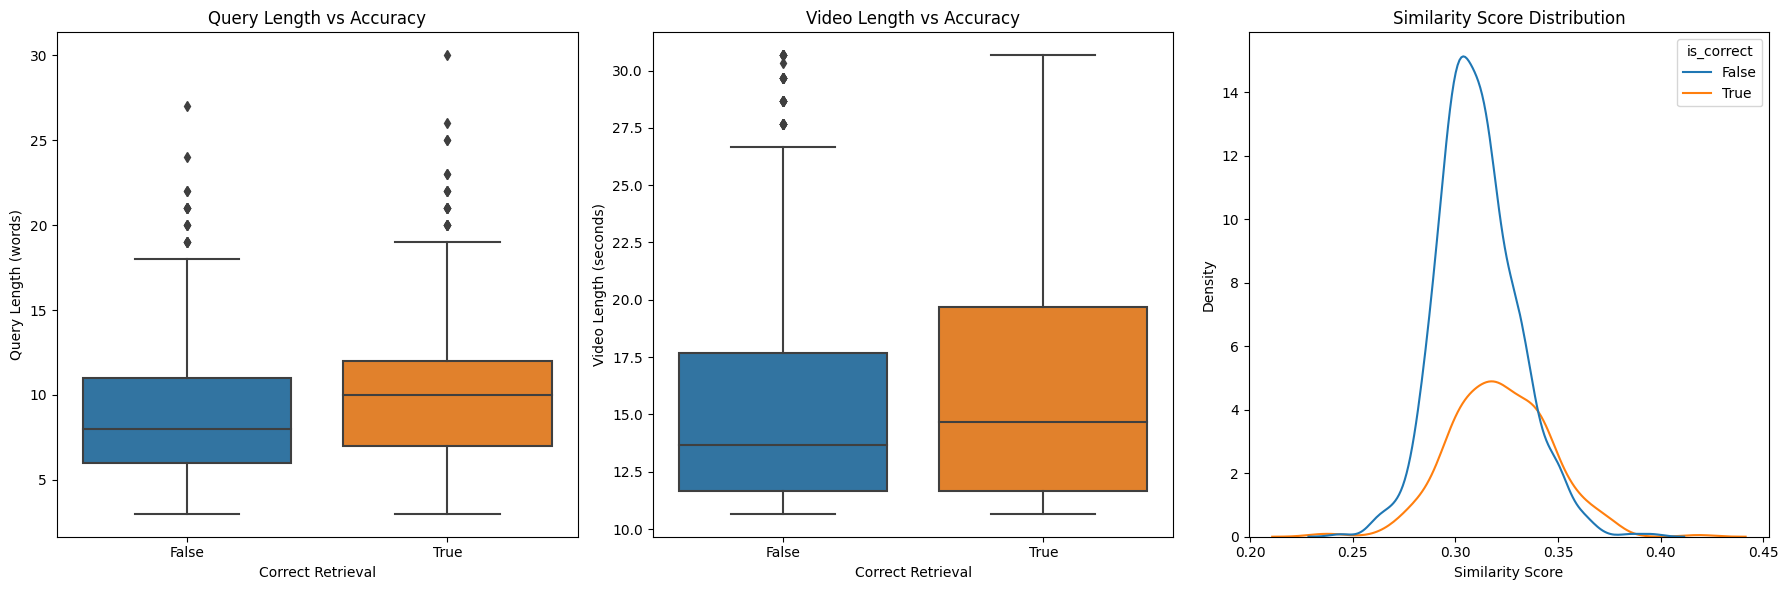


📊 BOTTOM LINE CONCLUSIONS:
1. Queries: LONGER queries perform better
   - Short query accuracy: 26.3%
   - Long query accuracy: 38.2%
   - Correlation with accuracy: 0.148

2. Videos: LONGER videos perform better
   - Short video accuracy: 28.2%
   - Long video accuracy: 34.5%
   - Correlation with accuracy: 0.064

3. Key Findings:
   - Average similarity for correct matches: 0.322
   - Average similarity for incorrect matches: 0.311
   - Overall correlation between similarity and accuracy: 0.235


In [31]:
# Run comprehensive error analysis
results_df, stats = video_dataset.analyze_errors_by_characteristics()

# Generate and print detailed report
report = video_dataset.error_analysis_report(results_df, stats)
print(report)

## Robustness

**Robustness Evaluation using Query Variations**

Testing how well our system handles different ways of describing the same video content:

1. **Process**:
  - Sample 50 videos from dataset
  - For each video's description:
    * Generate 3 alternative descriptions using LLM
    * Keep same meaning but vary word choice and structure
    * Run search with each variation
  - Compare results across original and variant queries

2. **We Measure**:
  - If correct video stays in top-k results across variations
  - How much ranking position changes
  - Changes in similarity scores
  - Consistency of results

**Key Metrics:**
- `maintained_in_top_k_ratio`: How often video stays in top results
- `mean_rank_difference`: Average change in ranking position
- `perfect_maintenance_ratio`: How often exact rank is preserved
- `similarity_correlation`: Consistency of similarity scores
- `avg_similarity_drop`: How much scores typically change

This helps understand system reliability when users phrase queries differently but mean the same thing.

100%|██████████| 50/50 [09:02<00:00, 10.86s/it]


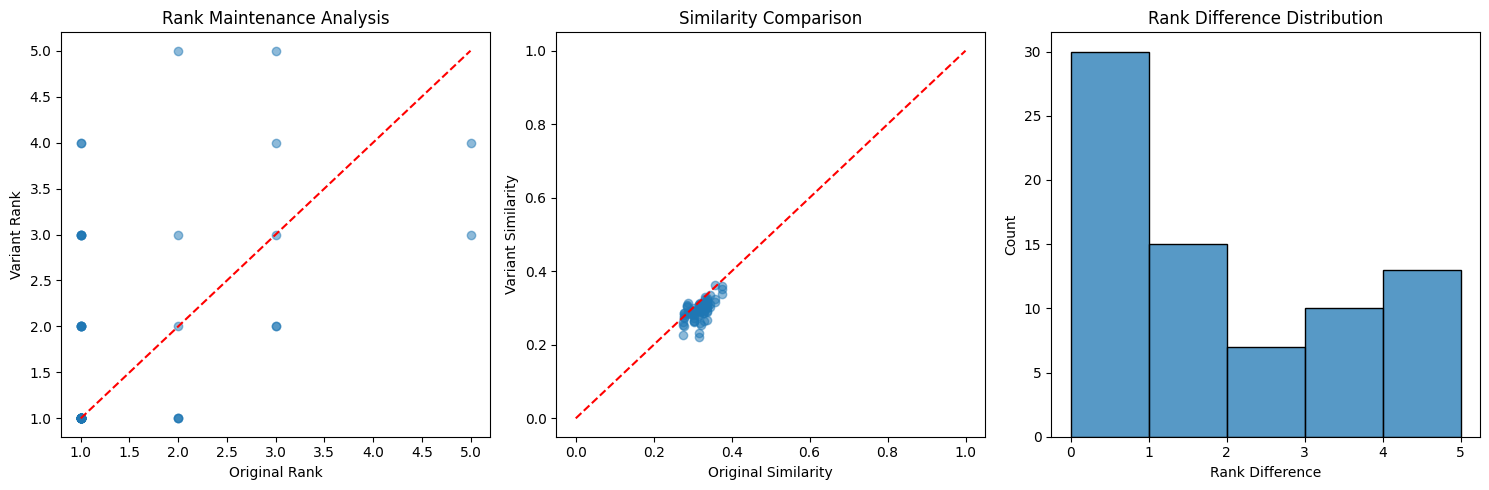


🎯 Examples where ranking was perfectly maintained:

Original [Rank: 1]: the opeing credit to gullah grub authentic cooking
Variant [Rank: 1]: Opening credits introduce Gullah Grub's genuine culinary heritage
Similarity: 0.359

Original [Rank: 3]: two astronauts experiencing a tense situation before relaxing afterwards
Variant [Rank: 3]: Cosmonauts confront a precarious predicament before unwinding with ease
Similarity: 0.266

Original [Rank: 1]: a woman holds up a leather jacket
Variant [Rank: 1]: She supports the worn leather garment
Similarity: 0.291

❌ Examples with largest rank differences (from successful retrievals):

Original [Rank: 1]: bill murray is covered in frosting
Variant [Rank: 4]: Bill Murray is smothered in a sweet, sticky layer
Original Similarity: 0.287
Variant Similarity: 0.313
Rank Change: From 1 to 4

Original [Rank: 1]: bill murray is covered in frosting
Variant [Rank: 4]: Frosting coats Bill Murray from head to toe
Original Similarity: 0.287
Variant Similarity:

In [32]:
import requests
import json
# Test system robustness using sentence variations
robustness_metrics, detailed_results = video_dataset.evaluate_robustness(
    num_samples=50,  # Number of videos to test
    num_variants=3,  # Number of variations per sentence
    top_k=5         # Consider top-k results
)

print("\nRobustness Metrics:")
for metric, value in robustness_metrics.items():
    print(f"{metric}: {value:.3f}")

# Additional Thoughts

**There's significant room to improve the current system. Key areas for enhancement include:**

**Enhanced Video Understanding**
- Better video embeddings through CLIP fine-tuning on domain-specific data
- Temporal information integration ([VIOLET](https://arxiv.org/abs/2111.12681), [All-in-one](https://arxiv.org/abs/2203.07303), [VideoMAE](https://arxiv.org/abs/2203.12602))
- Initial content detection using object detectors ([DINO v2](https://arxiv.org/abs/2304.07193)) or VLMs ([CoCa](https://arxiv.org/abs/2205.01917)) to narrow search space
- Smart data partitioning for efficient similarity search

**System Optimizations**
- Fine-tune CLIP on similar videos to improve domain understanding
- Vector database implementation ([FAISS](https://github.com/facebookresearch/faiss), [Milvus](https://milvus.io/)) for fast retrieval
- Quality threshold for filtering low-confidence matches
- Caching and batch processing for better performance

The video models mentioned (like VIOLET) incorporate temporal dynamics and better preserve sequential information. Fine-tuning CLIP on domain-specific video data would enhance embedding quality for particular use cases. Using content detection first (e.g., "This video contains cooking scenes") allows us to partition the search space and only compute cosine similarity with relevant video segments, making the system more efficient and accurate.